# 각종차트 그리기 연습
---

## 기본 OHLCv, MACD 과거 차트
* OHLCV 는 바로 받아오고, 평균은 pandas 로 계산

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from mpl_finance import candlestick_ohlc
import pandas as pd
import datetime
import matplotlib.ticker as ticker

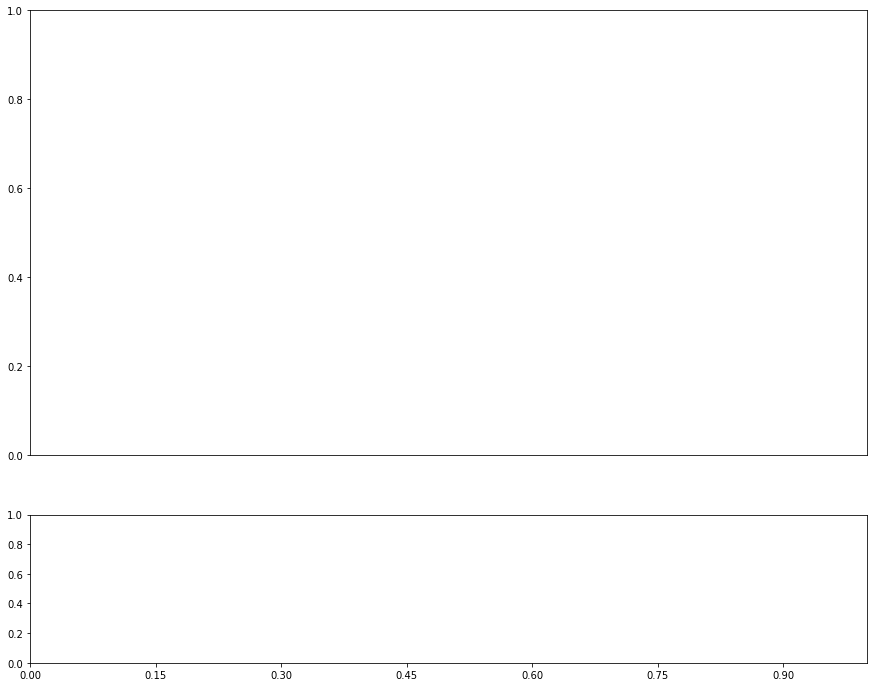

In [2]:
fig = plt.figure(figsize=(15, 12))
fig.set_facecolor('w')
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
axes = []
axes.append(plt.subplot(gs[0]))
axes.append(plt.subplot(gs[1], sharex=axes[0]))
axes[0].get_xaxis().set_visible(False)

# x 축을 조정합니다.
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(7))
#axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(7))

In [3]:
# 기간(일간) 으로 받기
import win32com.client
StockChart = win32com.client.Dispatch("CpSysDib.StockChart")
instCpCybos = win32com.client.Dispatch("CpUtil.CpCybos") # CpUtil 에 있는 CpCybos 클래스 기져와서 객체 생성

# 차트 요청 - 최근일 부터 개수 기준
def RequestFromTo(code, fromDate, toDate):
    print(code, fromDate, toDate)
    # 연결 여부 체크
    bConnect = instCpCybos.IsConnect
    if (bConnect == 0):
        print("PLUS가 정상적으로 연결되지 않음. ")
        return False

    StockChart.SetInputValue(0, code)  # 종목코드
    StockChart.SetInputValue(1, ord('1'))  # 기간으로 받기
    StockChart.SetInputValue(2, toDate)  # To 날짜
    StockChart.SetInputValue(3, fromDate)  # From 날짜
    StockChart.SetInputValue(4, 100)  # 최근 500일치
    StockChart.SetInputValue(5, [0, 2, 3, 4, 5, 8])  # 날짜,시가,고가,저가,종가,거래량
    StockChart.SetInputValue(6, ord('D'))  # '차트 주기 - 일간 차트 요청
    StockChart.SetInputValue(9, ord('1'))  # 수정주가 사용
    StockChart.BlockRequest()

    rqStatus = StockChart.GetDibStatus()
    rqRet = StockChart.GetDibMsg1()
    print("통신상태", rqStatus, rqRet)
    if rqStatus != 0:
        exit()

    len = StockChart.GetHeaderValue(3)

    dates = []
    opens = []
    highs = []
    lows = []
    closes = []
    vols = []
    for i in range(len):
        dates.append(StockChart.GetDataValue(0,i))
        opens.append(StockChart.GetDataValue(1, i))
        highs.append(StockChart.GetDataValue(2, i))
        lows.append(StockChart.GetDataValue(3, i))
        closes.append(StockChart.GetDataValue(4, i))
        vols.append(StockChart.GetDataValue(5, i))

    print(len)
    data = [dates, opens, highs, lows, closes, vols]
    data = pd.DataFrame(data).transpose()
    return pd.DataFrame(data)
    
#-----------------------

data = RequestFromTo('A035420', 20190102, 20190720)

A035420 20190102 20190720
통신상태 0 
136


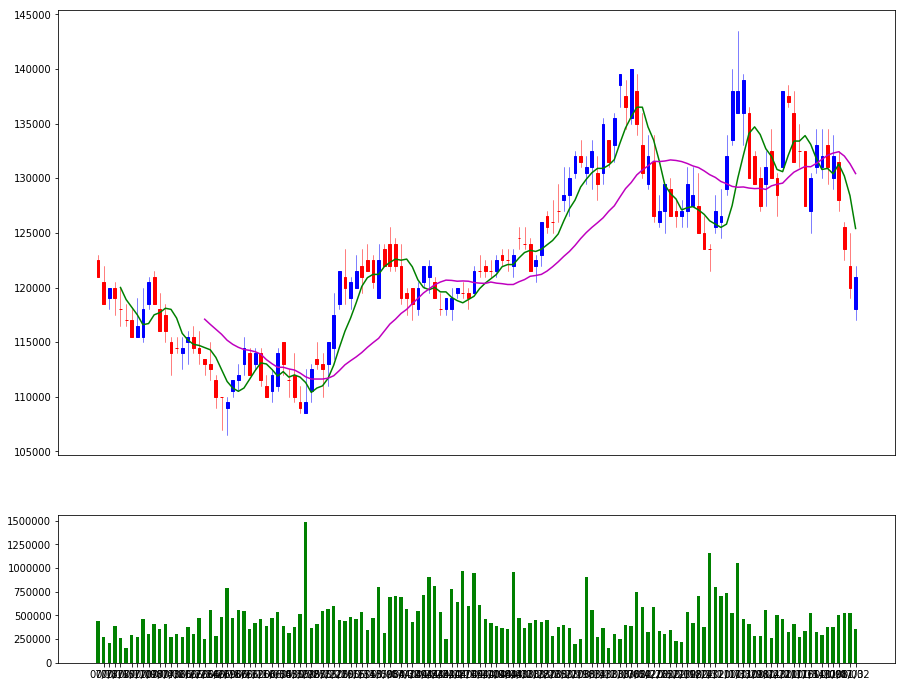

In [4]:
x = np.arange(len(data.index))
#print(x)
ohlc = np.transpose((data[1], data[2], data[3], data[4]))
np.reshape(x, (-1, 1))
#print(np.shape(x))
#print(np.shape(ohlc))
dohlc = np.hstack((np.reshape(x, (-1, 1)), ohlc))

# 봉차트
candlestick_ohlc(axes[0], dohlc, width=0.5, colorup='r', colordown='b')

ma5 = data[4].rolling(window=5).mean()
ma20 = data[4].rolling(window=20).mean()

axes[0].plot(x, ma5, label='ma5', color='g')
axes[0].plot(x, ma20, label='ma10', color='m')

# 거래량 차트
axes[1].bar(x, data[5], color='g', width=0.6, align='center')

# 날짜 표시
_xticks = []
_xlabels = []
_wd_prev = 0
for _x, d in zip(x, data[0].values):
    weekday = datetime.datetime.strptime(str(d), '%Y%m%d').weekday()
    if weekday <= _wd_prev:
        _xticks.append(_x)
        _xlabels.append(datetime.datetime.strptime(str(d), '%Y%m%d').strftime('%m/%d'))
    _wd_prev = weekday
axes[1].set_xticks(_xticks)
axes[1].set_xticklabels(_xlabels, rotation=0, minor=False)
fig

In [5]:
fig.clf()

## 실시간 차트 그리기 - 분봉
---
* csv 파일 만들고 주기적으로 저장
* 주기적으로 파일 접근해서 실시간 candleStick 를 animation 으로 그리기

In [6]:
import sys
from PyQt5.QtWidgets import *
import win32com.client
import ctypes
import nbimporter
import autologin
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from mpl_finance import candlestick_ohlc
import pandas as pd
import datetime
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import threading
import time
################################################
# PLUS 공통 OBJECT
g_objCodeMgr = win32com.client.Dispatch('CpUtil.CpCodeMgr')
g_objCpStatus = win32com.client.Dispatch('CpUtil.CpCybos')
g_objCpTrade = win32com.client.Dispatch('CpTrade.CpTdUtil')

Importing Jupyter notebook from autologin.ipynb


In [7]:
autolog = autologin.cpLogin()
autolog.connect()

com_error: (-2147417851, '서버에서 예외 오류가 발생했습니다.', None, None)

In [ ]:
# PLUS 실행 기본 체크 함수
def InitPlusCheck():
    # 프로세스가 관리자 권한으로 실행 여부
    if ctypes.windll.shell32.IsUserAnAdmin():
        print('정상: 관리자권한으로 실행된 프로세스입니다.')
    else:
        print('오류: 일반권한으로 실행됨. 관리자 권한으로 실행해 주세요')
        return False
 
    # 연결 여부 체크
    if (g_objCpStatus.IsConnect == 0):
        print("PLUS가 정상적으로 연결되지 않음. ")
        return False
 
    # # 주문 관련 초기화
    # if (g_objCpTrade.TradeInit(0) != 0):
    #     print("주문 초기화 실패")
    #     return False
 
    return True

In [ ]:
################################################
# CpEvent: 실시간 이벤트 수신 클래스
# 콜백 클래스, 핸들러
class CpEvent:
    
    def __init__(self):
        self.setGraph()
    
    def set_params(self, client, name, caller):
        self.client = client  # CP 실시간 통신 object
        self.name = name  # 서비스가 다른 이벤트를 구분하기 위한 이름
        self.caller = caller  # callback 을 위해 보관, 콜백을 요청한 주체
        self.x_cur = 1
        
    def OnReceived(self):
        # 실시간 처리 - 현재가 주문 체결
        if self.name == 'stockcur':
            code = self.client.GetHeaderValue(0)  # 초
            name = self.client.GetHeaderValue(1)  # 초
            day = self.client.GetHeaderValue(3)  # 시간
            open = self.client.GetHeaderValue(4)  # 시가
            high = self.client.GetHeaderValue(5)  # 고가
            low = self.client.GetHeaderValue(6)  # 저가
            vol = self.client.GetHeaderValue(9)  # 거래량

            timess = self.client.GetHeaderValue(18)  # 초
            exFlag = self.client.GetHeaderValue(19)  # 예상체결 플래그
            cprice = self.client.GetHeaderValue(13)  # 현재가
            diff = self.client.GetHeaderValue(2)  # 대비
            cVol = self.client.GetHeaderValue(17)  # 순간체결수량

            if exFlag != ord('2'):
                return

            item = {}
            item['code'] = code
            item['time'] = timess
            item['diff'] = diff
            item['cur'] = cprice
            item['vol'] = vol
            
            data_tmp = [[self.x_cur, open, high, low, vol]]

            # 현재가 업데이트
            #self.caller.updateCurData(item)
            time.sleep(5)
            self.x_cur += 1
            self.draw(data_tmp)
            return
        
    def setGraph(self):
        self.fig = plt.figure(figsize=(15, 12))
        self.fig.set_facecolor('w')
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
        self.axes = []
        self.axes.append(plt.subplot(gs[0]))
        self.axes.append(plt.subplot(gs[1], sharex=self.axes[0]))
        self.axes[0].get_xaxis().set_visible(False)

        # x 축을 조정합니다.
        self.axes[0].xaxis.set_major_locator(ticker.MaxNLocator(7))
        #axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
        self.axes[1].xaxis.set_major_locator(ticker.MaxNLocator(7))

    anim = FuncAnimation(fig, test, interval=25)
    anim.save('teste.mp4', fps=15)
    def draw(self, data):
        #x = self.x_cur
        #self.x_cur += 1
        #ohlc = np.transpose((data[1], data[2], data[3], data[4]))
        #np.reshape(x, (-1, 1))
        #print(np.shape(x))
        #print(np.shape(ohlc))
        #dohlc = np.hstack((np.reshape(x, (-1, 1)), ohlc))
        
        # 봉차트
        candlestick_ohlc(self.axes[0], data, width=0.5, colorup='r', colordown='b')

        #ma5 = data[4].rolling(window=5).mean()
        #ma20 = data[4].rolling(window=20).mean()

        #self.axes[0].plot(x, ma5, label='ma5', color='g')
        #self.axes[0].plot(x, ma20, label='ma10', color='m')

        # 거래량 차트
        #self.axes[1].bar(x, data[5], color='g', width=0.6, align='center')

        # 날짜 표시
        '''_xticks = []
        _xlabels = []
        _wd_prev = 0
        for _x, d in zip(x, data[0].values):
            weekday = datetime.datetime.strptime(str(d), '%Y%m%d').weekday()
            if weekday <= _wd_prev:
                _xticks.append(_x)
                _xlabels.append(datetime.datetime.strptime(str(d), '%Y%m%d').strftime('%m/%d'))
            _wd_prev = weekday
        self.axes[1].set_xticks(_xticks)
        self.axes[1].set_xticklabels(_xlabels, rotation=0, minor=False)'''
        self.fig.clf()
        

################################################
# plus 실시간 수신 base 클래스
class CpPublish:
    def __init__(self, name, serviceID):
        self.name = name
        self.obj = win32com.client.Dispatch(serviceID)
        self.bIsSB = False

    def Subscribe(self, var, caller):
        if self.bIsSB:
            self.Unsubscribe()
 
        if (len(var) > 0):
            self.obj.SetInputValue(0, var)
        
        # 콜백 클래스 - com 객체 를 연결. 이벤트 처리해 줌.
        # handler 는 CpEvent 클래스 형태? 핸들러
        handler = win32com.client.WithEvents(self.obj, CpEvent)
        handler.set_params(self.obj, self.name, caller)
        self.obj.Subscribe()
        self.bIsSB = True
 
    def Unsubscribe(self):
        if self.bIsSB:
            self.obj.Unsubscribe()
        self.bIsSB = False
 
 
################################################
# CpPBStockCur: 실시간 현재가 요청 클래스
class CpPBStockCur(CpPublish):
    def __init__(self):
        super().__init__('stockcur', 'DsCbo1.StockCur')
 
 
class CMinchartData:
    def __init__(self):
        self.minDatas = {}
        self.objCur = {}
 
    def stop(self):
        for k,v in self.objCur.items() :
            v.Unsubscribe()
 
 
    def addCode(self, code):
        if (code in self.minDatas) :
            return
 
        self.minDatas[code] = []
        self.objCur[code] = CpPBStockCur()
        self.objCur[code].Subscribe(code, self) # chart 의 self 객체는 이벤트를 요청한 주체
 

    def updateCurData(self, item):
        code = item['code']
        time  = item['time']
        cur = item['cur']
        self.makeMinchart(code, time, cur)
 
 
    def makeMinchart(self, code, time, cur) :
        hh, mm = divmod(time, 10000)
        mm, tt = divmod(mm, 100)
        mm += 1
        if (mm == 60) :
            hh += 1
            mm = 0
 
        hhmm = hh * 100 + mm
        if hhmm > 1530 :
            hhmm = 1530
        bFind = False
        minlen =len(self.minDatas[code])
        if (minlen > 0) :
            # 0 : 시간 1 : 시가 2: 고가 3: 저가 4: 종가
            if (self.minDatas[code][-1][0] == hhmm) :
                item = self.minDatas[code][-1]
                bFind = True
                item[4] = cur
                if (item[2] < cur):
                    item[2] = cur
                if (item[3] > cur):
                    item[3] = cur
 
        if bFind ==  False :
            self.minDatas[code].append([hhmm, cur, cur, cur, cur])
 
        return
 
    def print(self, code):
        print('====================================================-')
        print('분데이터 print', code, g_objCodeMgr.CodeToName(code))
        print('시간,시가,고가,저가,종가')
        for item in self.minDatas[code] :
            hh, mm = divmod(item[0], 100)
            print("%02d:%02d,%d,%d,%d,%d" %(hh, mm, item[1], item[2], item[3], item[4]))


In [ ]:
class MyWindow(QMainWindow):
    def __init__(self):
        super().__init__()
 
        # plus 상태 체크
        if InitPlusCheck() == False:
            exit()
 
        self.minData = CMinchartData()

        # 코스피 200 종목 가져와 추가
        self.codelist = g_objCodeMgr.GetGroupCodeList(180)
        for code in self.codelist :
            #print(code, g_objCodeMgr.CodeToName(code))
            self.minData.addCode(code)
 
 
        self.setWindowTitle("주식 분 차트 생성")
        self.setGeometry(300, 300, 300, 180)
 
        nH  = 20
 
        btnPrint = QPushButton('print', self)
        btnPrint.move(20, nH)
        btnPrint.clicked.connect(self.btnPrint_clicked)
        nH += 50
 
 
        btnExit = QPushButton('종료', self)
        btnExit.move(20, nH)
        btnExit.clicked.connect(self.btnExit_clicked)
        nH += 50
 
 
    def btnPrint_clicked(self):
        for i in range(2):
            self.minData.print(self.codelist[i])
            if i > 10: break
        return
 

    def btnExit_clicked(self):
        self.minData.stop()
        exit()
        return

if __name__ == "__main__":
    app = QApplication(sys.argv)
    myWindow = MyWindow()
    myWindow.show()
    app.exec_()    